In [5]:
#import packages
import networkx as nx
import json
from networkx.readwrite import json_graph

#load data
file_path = '/Users/brookefeinberg/SamplingBalancedForests/cnty_or.json'
with open(file_path, 'r') as file:
    data = json.load(file)
    oregon = json_graph.adjacency_graph(data)


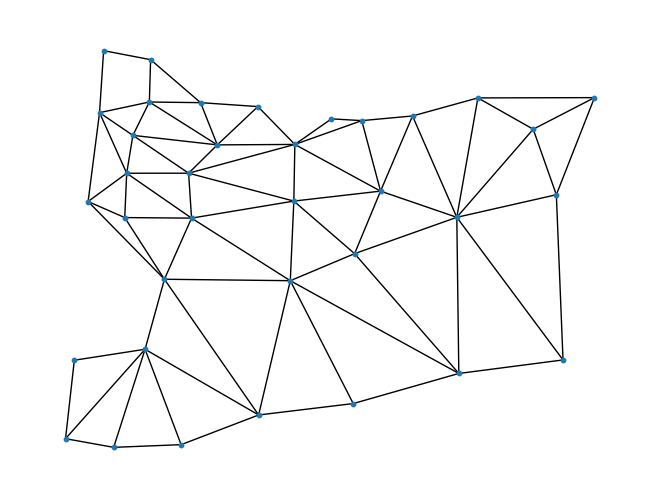

In [8]:
#plot of oregon
import matplotlib.pyplot as plt
node_locations = { v : ( float(oregon.nodes()[v]["INTPTLON20"]), float(oregon.nodes()[v]["INTPTLAT20"])) for v in oregon.nodes() }
plt.figure()
nx.draw(oregon, node_size = 10, pos = node_locations)
plt.show()

In [89]:
#Wilson's Algorithm

import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

class WilsonsAlgorithm:
    def __init__(self, graph):
        self.graph = graph  #store networkX graph 
        self.adj_list = {v: list(graph.neighbors(v)) for v in graph.nodes()}  #for each graph node return the neighbors and store it as a dictionary where node is the key and each value corresponds to a list of its neighbors 
        self.InTree = {node: False for node in self.adj_list}  #initalizes dictionary to keep track of whether nodes have been included in the spanning tree -- FALSE as initial value menaing node has yet to be included in the tree 
        self.Next = {node: None for node in self.adj_list}  #initalizes dictionary to track path each node takes in a random walk 
    
    def random_edge(self, v): #randomly selects an edge for a given node v 
        return random.choice(self.adj_list[v]) #retrieves the list of neighbors for node v in the adjacency list and randomly picks one -- simulating step ina  random walk 

    def RandomTreeWithRoot(self, r): #generate random spanning tree with r as the root node 
        self.InTree = {node: False for node in self.adj_list} #initalize all nodes as not in the spanning tree 
        self.InTree[r] = True  #mark root node as in the tree 
        self.Next[r] = -1  #root node has no parent aka no incoming edges 

        for node in self.adj_list: #loops through each nodein the graph, attempting to find a path to the root using a random walk 
            path = []  
            while not self.InTree[node]: #loop continues as long as node is not already in the spanning tree 
                path.append(node)  #record each step of the random walk 
                self.Next[node] = self.random_edge(node) #choose a random neighbor & record it as the next step in the walk (connects node to its next random neighbor in the path)
                node = self.Next[node]  #update next node and the new node so the loop continues till we reach a node already in the spanning tree 
            for vertex in path:  #loop has broken bc we've reached a node already part of the spanning tree 
                self.InTree[vertex] = True  #adds each vertex to the spanning tree from the root outward 

    def sample(self, seed=None):
        if seed is not None: #can include seed later on for reproducible results 
            random.seed(seed)
        root = random.choice(list(self.adj_list.keys()))  #picks a random node to be a root 
        self.RandomTreeWithRoot(root) #builds ranodm spannign tree with the ranodm root chosen 

        spanning_tree = []  #extract edges of spannign tree for plotting 
        for node in self.adj_list: 
            if self.Next[node] != -1 and self.Next[node] is not None: #find nodes connected to another node in the tree 
                spanning_tree.append((node, self.Next[node])) #addes connection or edge as a tuple of two nodes to the spanning tree list 
        return spanning_tree, root #returns all the edges in the form of (node1, node2) and the root node 

    def draw_tree(self, spanning_tree, root, node_locations): #plot the spanning tree on the graph
        plt.figure(figsize=(8, 8))
        nx.draw(self.graph, pos=node_locations, node_size=10, edge_color='lightgray') #draw original graph 
        nx.draw_networkx_edges(self.graph, pos=node_locations, edgelist=spanning_tree, edge_color='red', width=2) #draw spanning tree 
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=[root], node_color='yellow', node_size=50)  #draw root node 
        plt.show()

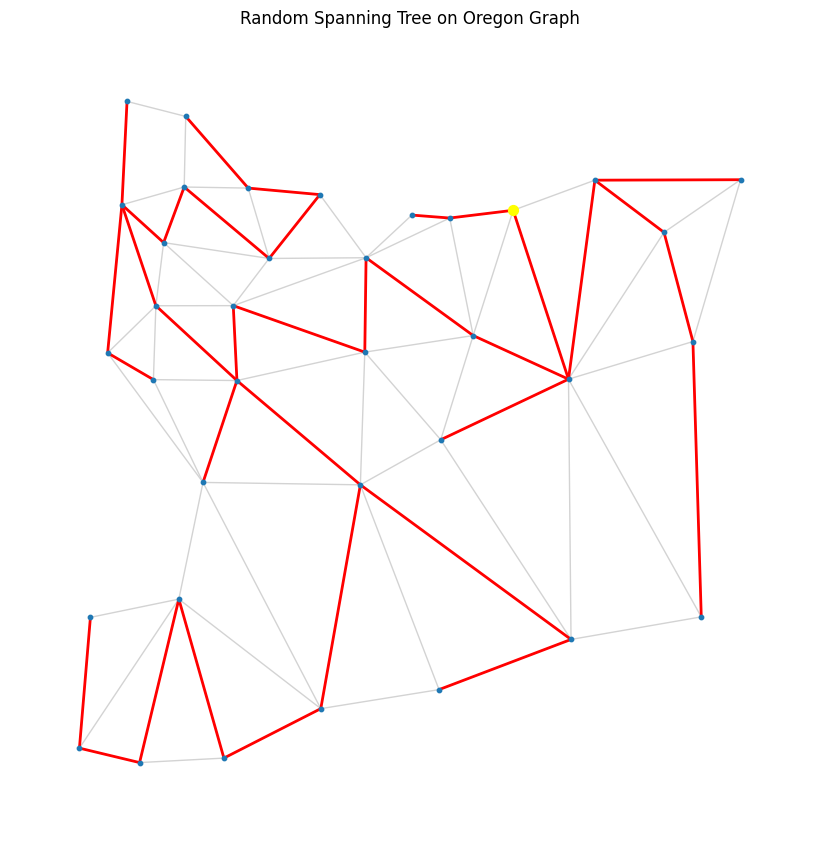

In [102]:
#plot of oregon's spannig tree 
 
node_locations = {v: (float(oregon.nodes[v]["INTPTLON20"]), float(oregon.nodes[v]["INTPTLAT20"])) for v in oregon.nodes()}
wilson = WilsonsAlgorithm(oregon)
spanning_tree, root = wilson.sample()
wilson.draw_tree(spanning_tree, root, node_locations)

In [105]:
'''
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

# Modified DFS-based partitioning for 3 partitions based on the number of edges
class DFSBalancedPartitioning:
    def __init__(self, graph, k=3):
        """
        Initialize the DFS-based partitioning algorithm for 3 partitions.
        
        :param graph: A NetworkX graph object.
        :param k: Number of partitions (3 in this case).
        """
        self.graph = graph
        self.k = k
        self.partition = {node: -1 for node in self.graph.nodes()}  # -1 means unassigned
        self.partition_edges = [0] * k  # Track the number of edges assigned to each partition

    def __dfs(self, node, part):
        """
        Perform DFS to attempt to partition the graph into 3 partitions.
        
        :param node: The current node in the DFS traversal.
        :param part: The partition to assign this node to.
        :return: True if successful, False if not.
        """
        self.partition[node] = part

        # Visit all neighbors and attempt to partition edges
        for neighbor in self.graph.neighbors(node):
            if self.partition[neighbor] == -1:  # Unvisited neighbor
                self.partition_edges[part] += 1  # Count edge for this partition
                if not self.__dfs(neighbor, (part + 1) % self.k):  # Alternate among 3 partitions
                    return False
            elif self.partition[neighbor] == part:
                return False
        return True

    def is_balanced_partition_possible(self):
        """
        Check if the graph can be split into 3 balanced partitions based on the number of edges.
        
        :return: True if partitioning is possible, False otherwise.
        """
        for node in self.graph.nodes():
            if self.partition[node] == -1:  # Unvisited node
                if not self.__dfs(node, 0):  # Try to assign to partition 0, then 1, then 2
                    return False
        
        # Check if the edge distribution across the partitions is balanced
        total_edges = self.graph.number_of_edges()
        target_edges = total_edges // self.k  # Target size for each partition
        max_diff = total_edges % self.k  # Allowable difference due to division
        
        # Ensure all partitions have edge counts within the target range plus the allowable difference
        return all(abs(self.partition_edges[i] - target_edges) <= max_diff for i in range(self.k))

    def draw_partitions(self, node_locations):
        """
        Visualize the partitions on the graph.
        
        :param node_locations: A dictionary of node positions (longitude, latitude).
        """
        plt.figure(figsize=(8, 8))  # Create a figure for the plot

        # Partition 0 nodes (colored blue)
        nodes_part_0 = [node for node, part in self.partition.items() if part == 0]
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=nodes_part_0, node_color='blue', node_size=50)
        
        # Partition 1 nodes (colored green)
        nodes_part_1 = [node for node, part in self.partition.items() if part == 1]
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=nodes_part_1, node_color='green', node_size=50)
        
        # Partition 2 nodes (colored red)
        nodes_part_2 = [node for node, part in self.partition.items() if part == 2]
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=nodes_part_2, node_color='red', node_size=50)

        # Draw edges in light gray
        nx.draw_networkx_edges(self.graph, pos=node_locations, edge_color='lightgray')

        plt.title("DFS-Based Balanced Partitioning into 3 Groups")
        plt.show()


# Assuming the Oregon graph and node locations are already provided
node_locations = {v: (float(oregon.nodes[v]["INTPTLON20"]), float(oregon.nodes[v]["INTPTLAT20"])) for v in oregon.nodes()}

# 1. Apply Wilson's Algorithm to the Oregon graph to generate a random spanning tree
wilson = WilsonsAlgorithm(oregon)
spanning_tree_edges, root = wilson.sample()

# 2. Convert the spanning tree into a NetworkX subgraph for partitioning
spanning_tree = nx.Graph()
spanning_tree.add_edges_from(spanning_tree_edges)

# 3. Apply DFS-based partitioning for 3 partitions based on the number of edges
dfs_partitioning = DFSBalancedPartitioning(spanning_tree, k=3)

# Check if the random spanning tree is splittable into 3 partitions
if dfs_partitioning.is_balanced_partition_possible():
    print("The random spanning tree can be split into 3 balanced partitions based on the number of edges.")
    # Visualize the balanced partitions
    dfs_partitioning.draw_partitions(node_locations)
else:
    print("The random spanning tree cannot be split into 3 balanced partitions based on the number of edges.")
'''

The random spanning tree cannot be split into 3 balanced partitions based on the number of edges.


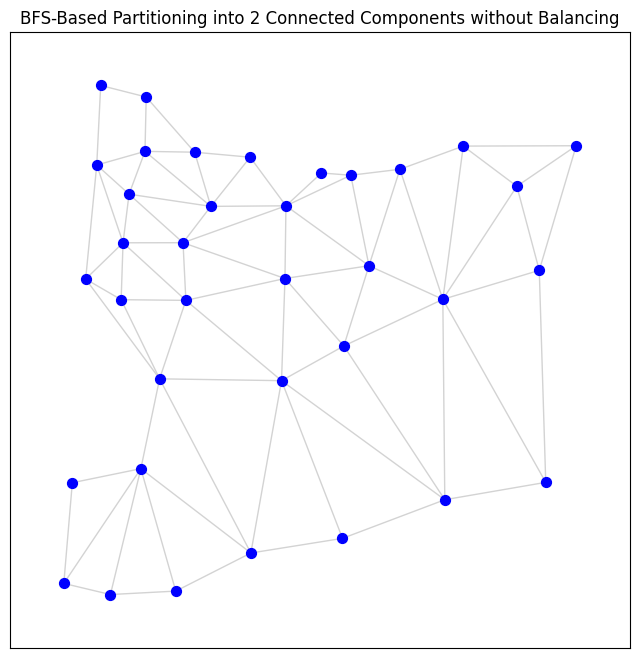

In [108]:
'''
# Modify the BFS-based partitioning to split the graph into 2 connected partitions without balancing
class BFSPartitioningWithoutBalancing:
    def __init__(self, graph, k=2):
        self.graph = graph
        self.k = k
        self.partition = {node: -1 for node in self.graph.nodes()}  # -1 means unassigned
        self.current_partition = 0  # Start with partition 0

    def bfs(self, start_node):
        """
        Perform BFS to grow the current partition.
        
        :param start_node: The starting node for the BFS traversal.
        """
        queue = [start_node]
        self.partition[start_node] = self.current_partition

        while queue:
            node = queue.pop(0)

            # Visit all neighbors and attempt to grow the current partition
            for neighbor in self.graph.neighbors(node):
                if self.partition[neighbor] == -1:  # Unvisited neighbor
                    self.partition[neighbor] = self.current_partition
                    queue.append(neighbor)

    def partition_graph(self):
        """
        Partition the graph into k connected components without balancing.
        """
        for node in self.graph.nodes():
            if self.partition[node] == -1:  # Unvisited node
                # Perform BFS starting from this node
                self.bfs(node)

                # Move to the next partition
                self.current_partition = (self.current_partition + 1) % self.k

    def draw_partitions(self, node_locations):
        """
        Visualize the partitions on the graph.
        
        :param node_locations: A dictionary of node positions (longitude, latitude).
        """
        plt.figure(figsize=(8, 8))  # Create a figure for the plot

        # Partition 0 nodes (colored blue)
        nodes_part_0 = [node for node, part in self.partition.items() if part == 0]
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=nodes_part_0, node_color='blue', node_size=50)
        
        # Partition 1 nodes (colored green)
        nodes_part_1 = [node for node, part in self.partition.items() if part == 1]
        nx.draw_networkx_nodes(self.graph, pos=node_locations, nodelist=nodes_part_1, node_color='green', node_size=50)

        # Draw edges in light gray
        nx.draw_networkx_edges(self.graph, pos=node_locations, edge_color='lightgray')

        plt.title("BFS-Based Partitioning into 2 Connected Components without Balancing")
        plt.show()

# Assuming the Oregon graph and node locations are already provided
node_locations = {v: (float(oregon.nodes[v]["INTPTLON20"]), float(oregon.nodes[v]["INTPTLAT20"])) for v in oregon.nodes()}

# Create the BFS partitioning object without balancing
bfs_partitioning_no_balance = BFSPartitioningWithoutBalancing(oregon, k=2)

# Partition the graph into 2 connected components
bfs_partitioning_no_balance.partition_graph()

# Visualize the partitions
bfs_partitioning_no_balance.draw_partitions(node_locations)

'''